# Quasar Top-Level Demo

`quasar` is a Python 3 environment for hardware and language agnostic quantum algorithms. Importing the library is as simple as:

In [1]:
import quasar

## High Level Overview: MC-VQE+AIEM 

This section is intended to demonstrate the utility of `quasar` for implementing a high-level quantum algorithm once, and then running it on multiple quantum backend environments. Let us suppose you have just come up with a new quantum algorithm, and now you want to code it up and try it out on different quantum circuit simulator and hardware backends. If you code the method using `quasar` primitives, this is very easily done. 

The case study today revolves around a method called MC-VQE+AIEM, which finds the few lowest energy states of large molecular complexes. The specific details of MC-VQE+AIEM are unimportant, other than that it is a promising NISQ algorithm for the domain application of chemistry simulations, and that it uses a number of quantum measurements and observable expectation values on a variety of different quantum circuits to solve each interesting molecular problem. More details about the specifics of MC-VQE+AIEM can be found in  R.M. Parrish, E.G. Hohenstein, P.L. McMahon, and T.J. Martinez, Phys. Rev. Lett. 122, 230401 (2019) or the corresponding arxiv preprint https://arxiv.org/pdf/1901.01234.pdf. 

We will start from our existing `quasar`-based implementation of MC-VQE+AIEM:

In [2]:
import mcvqe

The following code loads matrix elements from data files generated by some classical electronic structure computations to specify the forthcoming MC-VQE problem. This part is just technical, and is not important to the overall example.

In [3]:
filenames = ['../data/aiem/bchl-a-8-stack/tc/%s/exciton.dat' 
             % (A) for A in range(1,8+1)]
aiem_monomer = mcvqe.AIEMMonomer.from_tc_exciton_files(
    filenames=filenames,
    N=2,
    connectivity='linear',
    )

Now we spin up an `MCVQE` object (coded in `quasar`) and ask it to compute two states of this molecular system for us:

In [4]:
mcvqe_solver = mcvqe.MCVQE.from_options(
    aiem_monomer=aiem_monomer,
    nstate=2,
    )
mcvqe_solver.compute_energy()

==> MC-VQE+AIEM <==

Quantum Resources:
  Backend        = Quasar Simulator Backend (Statevector)
  Shots          = None
  Shots Subspace = None
  Shots Deriv    = None

AIEM Problem:
 N            = 2
 Ncis         = 3
 Nstate       = 2
 Connectivity = linear

CIS Verification:

State:       Match
0    :  -2.776E-17
1    :   1.214E-17

SA-VQE Weights:

State:      Weight
0    :   5.000E-01
1    :   5.000E-01

VQE Entangler Circuit:
  vqe_circuit_type = mark1x
  vqe_nparam       = 6

Initital VQE params guessed as zero.

 > BFGS Optimizer <

  maxiter       = 100
  g_convergence = 1.000E-06

 > End BFGS Optimizer <

Finished VQE Circuit:

T  : |0 |1|2 |3|4 |
                   
q0 : -Ry-@-Ry-@-Ry-
         |    |    
q1 : -Ry-X-Ry-X-Ry-

T  : |0 |1|2 |3|4 |

Finished VQE Parameters:

Index Time  Qubits     Name       Gate      :     Value
0     0     (0,)       theta      Ry        :  0.068010
1     0     (1,)       theta      Ry        :  0.045097
2     2     (0,)       theta      Ry

Great, we have a working MC-VQE+AIEM code running on our in-house `quasar` quantum circuit simulator. So far, that doesn't actually do anything intrinsically interesting. I.e., we could have coded this directly in `cirq`, `qiskit`, or whatever quantum circuit environment that you like.

But what if we wanted to manually specify a different MC-VQE entangler circuit, and at the same time we wanted to run the code using the IBM simulator? Using `quasar`, this is entirely straightforward.

First, let us suppose that we have a `cirq` implementation of an interesting MC-VQE entangler circuit:

In [5]:
import cirq
qubits = [cirq.LineQubit(A) for A in [0,1]]
vqe_circuit = cirq.Circuit()
vqe_circuit.append(cirq.Ry(0.0)(qubits[0]))
vqe_circuit.append(cirq.Ry(0.0)(qubits[1]))
vqe_circuit.append(cirq.CNOT(qubits[0], qubits[1]))
vqe_circuit.append(cirq.Ry(0.0)(qubits[0]))
vqe_circuit.append(cirq.Ry(0.0)(qubits[1]))
vqe_circuit.append(cirq.CNOT(qubits[0], qubits[1]))
vqe_circuit.append(cirq.Ry(0.0)(qubits[0]))
vqe_circuit.append(cirq.Ry(0.0)(qubits[1]))
print(vqe_circuit)

0: ───Ry(0.0π)───@───Ry(0.0π)───@───Ry(0.0π)───
                 │              │
1: ───Ry(0.0π)───X───Ry(0.0π)───X───Ry(0.0π)───


Now, let us spin up a `QiskitSimulatorBackend` object:

In [6]:
backend = quasar.QiskitSimulatorBackend()
print(backend)

Qiskit Simulator Backend


/anaconda3/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


Now, we spin up a new `MCVQE` object, with two new optional arguments specifying the MC-VQE entangler circuit (specified in `cirq`) and the desired backend (`qiskit`):

In [7]:
mcvqe_solver = mcvqe.MCVQE.from_options(
    backend=backend,
    vqe_circuit=vqe_circuit,
    aiem_monomer=aiem_monomer,
    nstate=2,
    )
mcvqe_solver.compute_energy()

==> MC-VQE+AIEM <==

Quantum Resources:
  Backend        = Qiskit Simulator Backend
  Shots          = None
  Shots Subspace = None
  Shots Deriv    = None

AIEM Problem:
 N            = 2
 Ncis         = 3
 Nstate       = 2
 Connectivity = linear

CIS Verification:

State:       Match
0    :  -2.776E-17
1    :   1.214E-17

SA-VQE Weights:

State:      Weight
0    :   5.000E-01
1    :   5.000E-01

VQE Entangler Circuit:
  vqe_circuit_type = custom
  vqe_nparam       = 6

Initial VQE params taken from input circuit.

 > BFGS Optimizer <

  maxiter       = 100
  g_convergence = 1.000E-06

 > End BFGS Optimizer <

Finished VQE Circuit:

T  : |0 |1|2 |3|4 |
                   
q0 : -Ry-@-Ry-@-Ry-
         |    |    
q1 : -Ry-X-Ry-X-Ry-

T  : |0 |1|2 |3|4 |

Finished VQE Parameters:

Index Time  Qubits     Name       Gate      :     Value
0     0     (0,)       theta      Ry        :  0.068010
1     0     (1,)       theta      Ry        :  0.045097
2     2     (0,)       theta      Ry      

This is exactly what we were looking for: the whole MC-VQE example ran on the IBM simulator backend in `qiskit`, with the MC-VQE entangler circuit template specified in `cirq`. We can similarly run this code on hardware (e.g., `QiskitHardwareBackend`, which takes extra arguments specifying which IBM processor to target) or on noise-model-including simulators. And all the while, the `MCVQE` code is extremely simple, because it does not have to know any details of which backend environment is being used.

In the following, we show some detail on the quantum primitives in `quasar` that the `MCVQE` code was built on and that allowed for this front-end/back-end versatility.

## Layer 1: The Quasar Circuit Class

At the core of `quasar` is a library for constructing and manipulating quantum circuits, centered around the `Circuit` class. This is a feature that is found in almost all quantum circuit environments.

### Simple Example: a GHZ Circuit

Here we build an empty 3-qubit `Circuit` object and then add an `H` (Hadamard) and a pair of `CX` (CNOT) gates to build a little 3-qubit GHZ circuit:

In [8]:
circuit = quasar.Circuit(N=3).H(0).CX(0,1).CX(1,2)
print(circuit)

T  : |0|1|2|
            
q0 : -H-@---
        |   
q1 : ---X-@-
          | 
q2 : -----X-

T  : |0|1|2|


We can easily iterate through the circuit's `gates` dictionary, which provides access to the time index, qubit indices, and `Gate` object for each gate in the circuit:

In [9]:
for key, gate in circuit.gates.items():
    time, qubits = key # Gates are keyed on (time, qubits) pairs
    print('%1d %6s: %2s' % (time, qubits, gate))

0   (0,):  H
1 (0, 1): CX
2 (1, 2): CX


The `Gate` object has a few simple attributes such as a `name`, number of qubits `N`, unitary matrix (for current parameters) `U`, and dictionary of `params`:

In [10]:
gate = circuit.gate(time=1, qubits=(0,1))
print(gate)
print(gate.name)
print(gate.N)
print(gate.U.real)
print(gate.params)

CX
CX
2
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
OrderedDict()


The `Circuit` object also has a few simple attributes such as number of qubits `N`, number of gates `ngate`, number of time intervals `ntime`, etc:

In [11]:
print(circuit.N)
print(circuit.ngate)
print(circuit.ngate1)
print(circuit.ngate2)
print(circuit.ntime)

3
3
1
2
3


### Next Example: a CIS Circuit

For our next example, we build a small configuration interaction singles (CIS) circuit which generates states of the form $|\Psi \rangle = \mu |0000 \rangle + \alpha |1000 \rangle + \beta |0100\rangle + \gamma |0010 \rangle + \delta |0001\rangle$. This comes up all the time in MC-VQE. To do this quickly, we first build a composite "gadget" circuit element:

In [12]:
gadget = quasar.Circuit(N=2).Ry(1).CZ(0,1).Ry(1).CX(1,0)
print(gadget)

T  : |0 |1|2 |3|
                
q0 : ----@----X-
         |    | 
q1 : -Ry-Z-Ry-@-

T  : |0 |1|2 |3|


Now we can build the full CIS circuit with an `Ry` gate and three copies of the gadget. The latter can be efficiently added using the `add_circuit` method - many other utility functions are also present in `Circuit` to assist with efficient circuit construction:

In [13]:
circuit = quasar.Circuit(N=4)
circuit.Ry(0, theta=0.1)
circuit.add_circuit(gadget, (0,1))
circuit.add_circuit(gadget, (1,2))
circuit.add_circuit(gadget, (2,3))
print(circuit)

T  : |0 |1|2 |3 |4|5 |6 |7|8 |9|
                                
q0 : -Ry-@----X-----------------
         |    |                 
q1 : -Ry-Z-Ry-@--@----X---------
                 |    |         
q2 : ---------Ry-Z-Ry-@--@----X-
                         |    | 
q3 : -----------------Ry-Z-Ry-@-

T  : |0 |1|2 |3 |4|5 |6 |7|8 |9|


A common feature of NISQ algorithms is the tuning of adjustable circuit parameters. For instance, all of the `Ry` gates in the circuit have adjustable rotation angles:

In [14]:
print(circuit.param_str)

Index Time  Qubits     Name       Gate      :     Value
0     0     (0,)       theta      Ry        :  0.100000
1     0     (1,)       theta      Ry        :  0.000000
2     2     (1,)       theta      Ry        :  0.000000
3     3     (2,)       theta      Ry        :  0.000000
4     5     (2,)       theta      Ry        :  0.000000
5     6     (3,)       theta      Ry        :  0.000000
6     8     (3,)       theta      Ry        :  0.000000



These parameters can be accessed and manipulated at the `Circuit` level - there is no need to go down to the individual `Gate` objects to update the parameters. By convention, the parameters appear sorted lexically by time interval, qubit indices, and then parameter order within the gate:

In [15]:
for key, param in circuit.params.items():
    time, qubits, name = key
    print('%2d %6s %6s: %14.6f' % (time, qubits, name, param))

 0   (0,)  theta:       0.100000
 0   (1,)  theta:       0.000000
 2   (1,)  theta:       0.000000
 3   (2,)  theta:       0.000000
 5   (2,)  theta:       0.000000
 6   (3,)  theta:       0.000000
 8   (3,)  theta:       0.000000


This lexical ordering allows us to set the values of the parameters using a list, through the `set_param_values` method:

In [16]:
circuit.set_param_values([0.6, 0.5, -0.5, 0.4, -0.4, 0.3, -0.3])
print(circuit.param_str)

Index Time  Qubits     Name       Gate      :     Value
0     0     (0,)       theta      Ry        :  0.600000
1     0     (1,)       theta      Ry        :  0.500000
2     2     (1,)       theta      Ry        : -0.500000
3     3     (2,)       theta      Ry        :  0.400000
4     5     (2,)       theta      Ry        : -0.400000
5     6     (3,)       theta      Ry        :  0.300000
6     8     (3,)       theta      Ry        : -0.300000



Now with nontrivial parameter values, we can simulate the action of the circuit on the $|0000\rangle$ starting state, and verify that a CIS state is generated:

In [17]:
print(circuit.simulate().real.round(3))

[ 0.825 -0.192  0.281  0.    -0.331  0.     0.     0.     0.305  0.
  0.     0.     0.     0.    -0.     0.   ]


Or with a pretty printing utility for the statevector:

In [18]:
print(quasar.format_statevector(circuit.simulate(), real=True))

+0.825336|0000>
-0.192451|0001>
+0.281305|0010>
-0.331026|0100>
+0.305078|1000>


We can also simulate sampling from the output of the quantum circuit:

In [19]:
measurement = circuit.measure(nmeasurement=1000)
print(measurement)

|0000> : 689
|0001> :  40
|0010> :  73
|0100> : 111
|1000> :  87



The results of the measurement are returned as a `MeasurementResult` object, which supports `dict`-type access:

In [20]:
print(measurement['0100'])

111


In [21]:
for ket, count in measurement.items():
    print('%5s : %3d' % (ket, count))

 0000 : 689
 0001 :  40
 0010 :  73
 0100 : 111
 1000 :  87


The `Ket` objects used as keys in `MeasurementResult` can be queried to determine the final state of each qubit:

In [22]:
print(ket[0])
print(ket[1])
print(ket[2])
print(ket[3])

1
0
0
0


## Layer 2: Backends, Statevectors, Measurements, and Paulis

In Layer 2, `quasar` provides access to circuit language translation and frontend/backend-agnostic quantum circuit operations.

This example will use the 3-qubit GHZ circuit:

In [23]:
quasar_circuit = quasar.Circuit(N=3).H(0).CX(0,1).CX(1,2)
print(quasar_circuit)

T  : |0|1|2|
            
q0 : -H-@---
        |   
q1 : ---X-@-
          | 
q2 : -----X-

T  : |0|1|2|


A key class in this layer is `Backend`, which represents the quantum circuit backend and simulator/hardware resources. `Backend` has many specializations to different quantum circuit simulator and hardware environments - we will play with three of these here:

In [24]:
quasar_backend = quasar.QuasarSimulatorBackend()
print(quasar_backend)
print(quasar_backend.summary_str)
print(quasar_backend.has_statevector)
print(quasar_backend.has_measurement)
print(quasar_backend.native_circuit_type)

Quasar Simulator Backend (Statevector)
Quasar: An Ultralite Quantum Circuit Simulator
   By Rob Parrish (rob.parrish@qcware.com)    
True
True
<class 'quasar.circuit.Circuit'>


In [25]:
qiskit_backend = quasar.QiskitSimulatorBackend()
print(qiskit_backend)
print(qiskit_backend.summary_str)
print(qiskit_backend.has_statevector)
print(qiskit_backend.has_measurement)
print(qiskit_backend.native_circuit_type)

Qiskit Simulator Backend
Qiskit Simulator Backend
True
True
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


In [26]:
cirq_backend = quasar.CirqSimulatorBackend()
print(cirq_backend)
print(cirq_backend.summary_str)
print(cirq_backend.has_statevector)
print(cirq_backend.has_measurement)
print(cirq_backend.native_circuit_type)

Cirq Simulator Backend
Cirq Simulator Backend
True
True
<class 'cirq.circuits.circuit.Circuit'>


One interesting operation is to obtain a backend-native representation of the quantum circuit:

In [27]:
qiskit_circuit = quasar.build_native_circuit(qiskit_backend, quasar_circuit)
print(qiskit_circuit)

           ┌───┐          
q316_0: |0>┤ H ├──■───────
           └───┘┌─┴─┐     
q316_1: |0>─────┤ X ├──■──
                └───┘┌─┴─┐
q316_2: |0>──────────┤ X ├
                     └───┘


In [28]:
cirq_circuit = quasar.build_native_circuit(cirq_backend, quasar_circuit)
print(cirq_circuit)

0: ───H───@───────
          │
1: ───────X───@───
              │
2: ───────────X───


In [29]:
print(quasar.build_quasar_circuit(cirq_circuit))

T  : |0|1|2|
            
q0 : -H-@---
        |   
q1 : ---X-@-
          | 
q2 : -----X-

T  : |0|1|2|


In the forthcoming examples, we will see that all of these top-level `quasar` quantum primitive operations can take an arbitrary quantum backend object, as well as an arbitrary frontend representation of the quantum circuit. To facilitate this, up to two language translation steps are used, if needed: an input circuit is translated from frontend native form to `quasar`, and then from `quasar` to the backend native form. This means that one only has to write `to_quasar` and `from_quasar` translation layers for each new backend environment, rather than to maintain a quadratic matrix of translation utilities:

In [30]:
circuits = [quasar_circuit, qiskit_circuit, cirq_circuit]
backends = [quasar_backend, qiskit_backend, cirq_backend]

Here, we simulate the statevector for all of these circuit representations on all backend environments:

In [31]:
for backend in backends:
    for circuit in circuits:
        print(quasar.run_statevector(backend, circuit).real.round(3))

[0.707 0.    0.    0.    0.    0.    0.    0.707]
[0.707 0.    0.    0.    0.    0.    0.    0.707]
[0.707 0.    0.    0.    0.    0.    0.    0.707]
[0.707 0.    0.    0.    0.    0.    0.    0.707]
[0.707 0.    0.    0.    0.    0.    0.    0.707]
[0.707 0.    0.    0.    0.    0.    0.    0.707]
[ 0.707  0.     0.     0.    -0.    -0.    -0.     0.707]
[ 0.707  0.     0.     0.    -0.    -0.    -0.     0.707]
[ 0.707  0.     0.     0.    -0.    -0.    -0.     0.707]


And similarly for measurements:

In [32]:
for backend in backends:
    for circuit in circuits:
        print(quasar.run_measurement(backend, circuit, nmeasurement=1000))

|000> : 472
|111> : 528

|000> : 534
|111> : 466

|000> : 506
|111> : 494

|000> : 520
|111> : 480

|000> : 489
|111> : 511

|000> : 514
|111> : 486

|000> : 503
|111> : 497

|000> : 497
|111> : 503

|000> : 517
|111> : 483



Another key operation on NISQ hardware is the manipulation of Pauli operators and the efficient evaluation of expectation values of a large number of Pauli strings with a minimal number of quantum measurements. `quasar` provides a Pauli algebra utility through the `Pauli` class: 

In [33]:
I, X, Y, Z = quasar.Pauli.IXYZ()
pauli = I + Z[0] + Z[1] + Z[2] 
pauli += Z[0] * Z[1] + Z[1] * Z[2] 
pauli += Z[0] * Z[1] * Z[2]
print(pauli)

+1.0*I
+1.0*Z0
+1.0*Z1
+1.0*Z2
+1.0*Z0*Z1
+1.0*Z1*Z2
+1.0*Z0*Z1*Z2


Pauli expectation values may be computed by statevector simulation (simulating infinite averaging over measurements):

In [34]:
print(quasar.run_pauli_expectation(qiskit_backend, quasar_circuit, pauli, nmeasurement=None))

<I> = 1.0
<Z0> = 2.220446049250313e-16
<Z1> = 2.220446049250313e-16
<Z2> = 2.220446049250313e-16
<Z0*Z1> = 1.0
<Z1*Z2> = 1.0
<Z0*Z1*Z2> = 2.220446049250313e-16


Or by measurement of the output of the quantum circuit:

In [35]:
print(quasar.run_pauli_expectation(qiskit_backend, quasar_circuit, pauli, nmeasurement=1000))

<I> = 1.0
<Z0> = 0.016
<Z1> = 0.016
<Z2> = 0.016
<Z0*Z1> = 1.0
<Z1*Z2> = 1.0
<Z0*Z1*Z2> = 0.016


## Layer 3: Gradients, Hessians, and Tomography

From the quantum primitives in Layer 2 above, one can construct additional layers of advanced quantum primitives that allow for succinct implementation of many NISQ algorithms. For instance, many variational algorithms like VQE require knowledge of the gradients, Hessians, and explicit analytical tomography formulae for Pauli expectation values as a function of the circuit parameters. Here we look at a case study of these advanced primitives for a 2-qubit CIS circuit plus trailing `Ry` gates:

In [36]:
circuit = quasar.Circuit(N=2).Ry(0, theta=0.1)
circuit.Ry(1, theta=-0.2).CZ(0,1).Ry(1, theta=+0.2).CX(1,0)
circuit.Ry(0, theta=0.0).Ry(1, theta=0.0)
print(circuit)
print('')
print(circuit.param_str)

T  : |0 |1|2 |3|4 |
                   
q0 : -Ry-@----X-Ry-
         |    |    
q1 : -Ry-Z-Ry-@-Ry-

T  : |0 |1|2 |3|4 |

Index Time  Qubits     Name       Gate      :     Value
0     0     (0,)       theta      Ry        :  0.100000
1     0     (1,)       theta      Ry        : -0.200000
2     2     (1,)       theta      Ry        :  0.200000
3     4     (0,)       theta      Ry        :  0.000000
4     4     (1,)       theta      Ry        :  0.000000



With expectation values taken over the following Pauli operator:

In [37]:
pauli = I - 0.4 * Z[0] - 0.5 * Z[1]
pauli += 0.1 * X[0] * X[1] + 0.2 * X[0] * Z[1] 
pauli += 0.3 * X[1] * Z[0] + 0.4 * Z[0] * Z[1]
print(pauli)

+1.0*I
-0.4*Z0
-0.5*Z1
+0.1*X0*X1
+0.2*X0*Z1
+0.3*X1*Z0
+0.4*Z0*Z1


We will use the following number of measurements and backend:

In [38]:
nmeasurement = 1000
backend = quasar.QuasarSimulatorBackend()

First, there is a quantum primitive to compute the total observable expectation value $O (\{ \theta_g \}) \equiv \langle \Psi (\{ \theta_g \} ) | \hat O | \Psi (\{ \theta_g \})\rangle$ at the current parameter set $\{ \theta_g \}$:

In [39]:
value = quasar.run_observable_expectation_value(
    backend, circuit, pauli, nmeasurement=nmeasurement)
print(value)

0.5489


Next, there is a quantum primitive to compute the gradient of the total observable expectation value with respect to the circuit parameters $\frac{\partial O}{\partial \theta_g}$. This can be restricted to user-desired parameter indices to lower the cost, using the `param_indices` optional argument:

In [40]:
gradient = quasar.run_observable_expectation_value_gradient(
    backend, circuit, pauli, nmeasurement=nmeasurement, param_indices=[3,4])
print(gradient)

[0.3946 0.632 ]


Next, there is a quantum primitive to compute the Hessian of the total observable expectation value with respect to the circuit parameters $\frac{\partial^2 O}{\partial \theta_g \partial \theta_h}$. This can be restricted to user-desired parameter indices to lower the cost, using the `param_indices1`/`param_indices2` optional arguments:

In [41]:
hessian = quasar.run_observable_expectation_value_hessian(
    backend, circuit, pauli, nmeasurement=nmeasurement, param_indices1=[3,4], param_indices2=[3,4])
print(hessian)

[[-0.1881  0.1196]
 [ 0.1196  0.1885]]


Another very interesting quantum primitive is "partial parameter tomography", and approach where a few carefully selected observable expectation values can inform us about the analytical formula for the observable expectation value as a few active parameters are varied, with the rest of the parameters are frozen. In this example, we determine the tomography of the observable expectation value as the parameters of the trailing VQE-like $R_y$ gates are varied:

In [42]:
tomography = quasar.run_observable_expectation_value_tomography(
    backend, circuit, pauli, nmeasurement=nmeasurement, param_indices=[3,4])
print(tomography)

Determining this `Tomography` object required sampling the observable expectation value at $3^N$ parameter combinations (9 total for this 2-parameter tomography example):

In [43]:
T = quasar.RotationTomography.quad_x(tomography.nparam)
print(T)

[[[-1.04719755 -1.04719755 -1.04719755]
  [ 0.          0.          0.        ]
  [ 1.04719755  1.04719755  1.04719755]]

 [[-1.04719755  0.          1.04719755]
  [-1.04719755  0.          1.04719755]
  [-1.04719755  0.          1.04719755]]]


After the `Tomography` object is obtained, we can use it **classically** to compute the observable expectation value at any parameter combination in the active two parameters:

In [44]:
import numpy as np
params = np.array(np.meshgrid(*([np.linspace(-np.pi / 2.0, +np.pi / 2.0, 50)]*2), indexing='ij'))
O = tomography.compute_observable_expectation_value(params)

This can be useful, e.g., for classically determining the optimal parameter combination in the active parameters, the basis for a method we call "Jacobi optimization",

In [45]:
params_0 = tomography.optimize_jacobi_1(d=0)
params_1 = tomography.optimize_jacobi_1(d=1)
params_opt = tomography.optimize_jacobi_1_best()
print(params_opt[:,-1])

[-0.08465446 -0.67452203]


Or even for simply plotting the value of the observable expectation value as a function of the active parameter combinations:

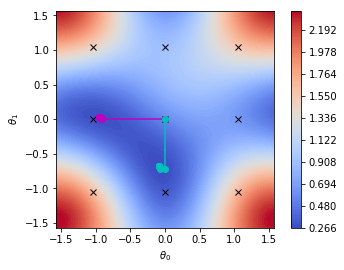

In [46]:
import matplotlib.pyplot as plt
levels = np.linspace(np.min(O), np.max(O), 100)
plt.clf()
plt.contourf(params[0], params[1], O, levels, cmap=plt.get_cmap('coolwarm'))
plt.plot(T[0], T[1], 'kx')
plt.plot(params_0[0], params_0[1], 'm-o')
plt.plot(params_1[0], params_1[1], 'c-o')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.axis('square')
plt.colorbar()
plt.show()

All of the above Level-3 primitives involve a number of carefully chosen Pauli expectation values selected on a widely spaced quadrature grid to prevent numerical cancellation in the presence of statistical measurement noise. However, the technical details are all wrapped up in the implementations of the primitives themselves, and the user can instead focus on using the primitives to go and implement the physical crux of the quantum algorithm.